In [1]:
import jax.numpy as jnp
import jax.random as jr
import jax

import imageio
import os

In [ ]:
def boids_simulation(
    num_boids, num_steps, rng_key,
    pheromone_boid_params, seeking_boid_params,
    space_size=50.0, max_velocity=0.2, min_velocity=0.05, avoid_edges=False, edge_avoidance_strength=1.0,
    pheromone_decay=0.001, pheromone_deposit_interval=5, FOV=jnp.pi/2
):
    key, subkey1, subkey2 = jr.split(rng_key, 3)
    positions = jr.uniform(subkey1, (num_boids, 2), minval=0.0, maxval=space_size)
    velocities = jr.uniform(subkey2, (num_boids, 2), minval=-0.1, maxval=0.1)
    pheromone_grid = jnp.zeros((int(space_size), int(space_size)))

    num_depositors = int(num_boids * pheromone_boid_params.get("fraction", 1.0))
    num_seekers = int(num_boids * seeking_boid_params.get("fraction", 1.0))
    pheromone_boids = jnp.arange(num_boids) < num_depositors
    seeking_boids = (jnp.arange(num_boids) >= num_boids - num_seekers)

    def per_boid_param(param_name):
        arr = jnp.where(
            pheromone_boids,
            pheromone_boid_params[param_name],
            seeking_boid_params[param_name]
        )
        return arr

    separation = per_boid_param("separation")
    alignment = per_boid_param("alignment")
    cohesion = per_boid_param("cohesion")
    pheromone_sensitivity = per_boid_param("pheromone_sensitivity")
    separation_radius = per_boid_param("separation_radius")
    alignment_radius = per_boid_param("alignment_radius")
    cohesion_radius = per_boid_param("cohesion_radius")
    pheromone_radius = per_boid_param("pheromone_radius")  # Not used in this approach

    def step(carry, t):
        positions, velocities, pheromone_grid = carry
        diff = positions[:, None, :] - positions[None, :, :]
        distances = jnp.linalg.norm(diff, axis=-1)

        sep_mask = distances < separation_radius[:, None]
        ali_mask = distances < alignment_radius[:, None]
        coh_mask = distances < cohesion_radius[:, None]

        vel_unit = velocities / jnp.linalg.norm(velocities, axis=1, keepdims=True)
        diff_unit = diff / (distances[..., None] + 1e-8)
        cos_angles = jnp.einsum('ij,ikj->ik', vel_unit, diff_unit)
        angle_mask = cos_angles > jnp.cos(FOV)
        sep_mask = sep_mask & angle_mask
        ali_mask = ali_mask & angle_mask
        coh_mask = coh_mask & angle_mask

        separation_vector = jnp.sum(jnp.where(sep_mask[..., None], -diff, 0.0), axis=1)
        mask_sum = jnp.sum(ali_mask, axis=1, keepdims=True)
        safe_div_vel = lambda numerator, denom, velocity: jnp.where(denom > 0, numerator / denom, velocity)
        local_avg_velocity = safe_div_vel(jnp.sum(jnp.where(ali_mask[..., None], velocities[None, :, :], 0.0), axis=1), mask_sum, velocities)
        alignment_vector = local_avg_velocity - velocities
        save_div_com = lambda numerator, denom, position: jnp.where(denom > 0, numerator / denom, position)
        local_center_of_mass = save_div_com(jnp.sum(jnp.where(coh_mask[..., None], positions[None, :, :], 0.0), axis=1), jnp.sum(coh_mask, axis=1, keepdims=True), positions)
        cohesion_vector = local_center_of_mass - positions

        edge_avoidance_vector = jnp.zeros_like(positions)
        if avoid_edges:
            edge_threshold = space_size * 0.1
            edge_avoidance_vector += jnp.where(positions < edge_threshold, edge_avoidance_strength * (edge_threshold - positions), 0.0)
            edge_avoidance_vector += jnp.where(positions > space_size - edge_threshold, edge_avoidance_strength * (space_size - edge_threshold - positions), 0.0)

        # Pheromone depositors
        def deposit_pheromones(_):
            deposit_positions = positions[pheromone_boids].astype(int)
            return pheromone_grid.at[deposit_positions[:, 0], deposit_positions[:, 1]].add(1.0)
        
        pheromone_grid = jax.lax.cond(
            t % pheromone_deposit_interval == 0,
            deposit_pheromones,
            lambda _: pheromone_grid,
            operand=None
        )

        # --- NEW: Compute pheromone gradient for the whole grid ---
        grad_y, grad_x = jnp.gradient(pheromone_grid)
        # Stack gradients for easier indexing
        grad_grid = jnp.stack([grad_x, grad_y], axis=-1)  # shape (H, W, 2)

        # Sample gradient at each boid's integer position (with toroidal wrapping)
        pos_int = positions.astype(int) % int(space_size)
        grad_at_boid = grad_grid[pos_int[:, 0], pos_int[:, 1]]  # shape (N, 2)

        # FOV mask: only use gradient if it's in the FOV of the boid
        vel_norm = velocities / (jnp.linalg.norm(velocities, axis=1, keepdims=True) + 1e-8)
        grad_norm = grad_at_boid / (jnp.linalg.norm(grad_at_boid, axis=1, keepdims=True) + 1e-8)
        cos_angle = jnp.sum(vel_norm * grad_norm, axis=1)
        in_fov = cos_angle > jnp.cos(FOV)
        pheromone_vector = jnp.where(in_fov[:, None], grad_at_boid, 0.0)
        # pheromone_vector = jnp.where(seeking_boids[:, None], pheromone_vector, 0.0)

        velocities += (
            separation[:, None] * separation_vector +
            alignment[:, None] * alignment_vector +
            cohesion[:, None] * cohesion_vector +
            edge_avoidance_vector +
            pheromone_sensitivity[:, None] * pheromone_vector
        ) / num_boids

        velocity_magnitudes = jnp.linalg.norm(velocities, axis=1, keepdims=True)
        velocities = jnp.where(velocity_magnitudes > max_velocity, velocities * (max_velocity / velocity_magnitudes), velocities)
        velocities = jnp.where(velocity_magnitudes < min_velocity, velocities * (min_velocity / velocity_magnitudes), velocities)

        positions += velocities
        positions = jnp.mod(positions, space_size)
        pheromone_grid *= (1 - pheromone_decay)

        return (positions, velocities, pheromone_grid), (positions, velocities, pheromone_grid)

    (final_positions, final_velocities, final_pheromone_grid), (position_history, velocity_history, pheromone_history) = jax.lax.scan(
        step, (positions, velocities, pheromone_grid), jnp.arange(num_steps)
    )

    return position_history, velocity_history, pheromone_history, final_positions, final_velocities
# ...existing code...

In [12]:
def boids_simulation(
    num_boids, num_steps, rng_key,
    pheromone_boid_params, seeking_boid_params,
    space_size=50.0, max_velocity=0.08, min_velocity=0.03, avoid_edges=False, edge_avoidance_strength=1.0,
    pheromone_decay=0.002, pheromone_deposit_interval=10, FOV=jnp.pi/3
):
    key, subkey1, subkey2 = jr.split(rng_key, 3)
    positions = jr.uniform(subkey1, (num_boids, 2), minval=0.0, maxval=space_size)
    # or put the positions in the middle of the space
    positions = jnp.full((num_boids, 2), space_size / 2)
    velocities = jr.uniform(subkey2, (num_boids, 2), minval=-0.1, maxval=0.1)
    pheromone_grid = jnp.zeros((int(space_size), int(space_size)))

    num_depositors = int(num_boids * pheromone_boid_params.get("fraction", 1.0))
    num_seekers = int(num_boids * seeking_boid_params.get("fraction", 1.0))
    pheromone_boids = jnp.arange(num_boids) < num_depositors
    seeking_boids = (jnp.arange(num_boids) >= num_boids - num_seekers)

    def per_boid_param(param_name):
        arr = jnp.where(
            pheromone_boids,
            pheromone_boid_params[param_name],
            seeking_boid_params[param_name]
        )
        return arr

    separation = per_boid_param("separation")
    alignment = per_boid_param("alignment")
    cohesion = per_boid_param("cohesion")
    pheromone_sensitivity = per_boid_param("pheromone_sensitivity")
    separation_radius = per_boid_param("separation_radius")
    alignment_radius = per_boid_param("alignment_radius")
    cohesion_radius = per_boid_param("cohesion_radius")
    pheromone_radius = per_boid_param("pheromone_radius")  # Not used in this approach
    wander = per_boid_param("wander")

    def step(carry, t):
        positions, velocities, pheromone_grid = carry
        diff = positions[:, None, :] - positions[None, :, :]
        distances = jnp.linalg.norm(diff, axis=-1)

        sep_mask = distances < separation_radius[:, None]
        ali_mask = distances < alignment_radius[:, None]
        coh_mask = distances < cohesion_radius[:, None]

        vel_unit = velocities / jnp.linalg.norm(velocities, axis=1, keepdims=True)
        diff_unit = diff / (distances[..., None] + 1e-8)
        cos_angles = jnp.einsum('ij,ikj->ik', vel_unit, diff_unit)
        angle_mask = cos_angles > jnp.cos(FOV)
        sep_mask = sep_mask & angle_mask
        ali_mask = ali_mask & angle_mask
        coh_mask = coh_mask & angle_mask

        separation_vector = jnp.sum(jnp.where(sep_mask[..., None], -diff, 0.0), axis=1)
        mask_sum = jnp.sum(ali_mask, axis=1, keepdims=True)
        safe_div_vel = lambda numerator, denom, velocity: jnp.where(denom > 0, numerator / denom, velocity)
        local_avg_velocity = safe_div_vel(jnp.sum(jnp.where(ali_mask[..., None], velocities[None, :, :], 0.0), axis=1), mask_sum, velocities)
        alignment_vector = local_avg_velocity - velocities
        save_div_com = lambda numerator, denom, position: jnp.where(denom > 0, numerator / denom, position)
        local_center_of_mass = save_div_com(jnp.sum(jnp.where(coh_mask[..., None], positions[None, :, :], 0.0), axis=1), jnp.sum(coh_mask, axis=1, keepdims=True), positions)
        cohesion_vector = local_center_of_mass - positions

        edge_avoidance_vector = jnp.zeros_like(positions)
        if avoid_edges:
            edge_threshold = space_size * 0.1
            edge_avoidance_vector += jnp.where(positions < edge_threshold, edge_avoidance_strength * (edge_threshold - positions), 0.0)
            edge_avoidance_vector += jnp.where(positions > space_size - edge_threshold, edge_avoidance_strength * (space_size - edge_threshold - positions), 0.0)

        # Pheromone depositors
        def deposit_pheromones(_):
            deposit_positions = positions[pheromone_boids].astype(int)
            return pheromone_grid.at[deposit_positions[:, 0], deposit_positions[:, 1]].add(1.0)
        
        pheromone_grid = jax.lax.cond(
            t % pheromone_deposit_interval == 0,
            deposit_pheromones,
            lambda _: pheromone_grid,
            operand=None
        )

        # --- Compute local pheromone gradient for each boid ---
        def local_gradient(pos):
            patch_radius = 2  # e.g., 2 for a 5x5 patch
            patch_size = 2 * patch_radius + 1
            # Pad grid for toroidal wrapping
            padded = jnp.pad(pheromone_grid, patch_radius, mode='wrap')
            pos_int = pos.astype(int) + patch_radius
            # Extract patch
            patch = jax.lax.dynamic_slice(
                padded,
                (pos_int[0] - patch_radius, pos_int[1] - patch_radius),
                (patch_size, patch_size)
            )
            grad_y, grad_x = jnp.gradient(patch)
            # Center of patch is at (patch_radius, patch_radius)
            return jnp.array([grad_x[patch_radius, patch_radius], -grad_y[patch_radius, patch_radius]])
        grad_at_boid = jax.vmap(local_gradient)(positions)

        # FOV mask: only use gradient if it's in the FOV of the boid
        vel_norm = velocities / (jnp.linalg.norm(velocities, axis=1, keepdims=True) + 1e-8)
        grad_norm = grad_at_boid / (jnp.linalg.norm(grad_at_boid, axis=1, keepdims=True) + 1e-8)
        cos_angle = jnp.sum(vel_norm * grad_norm, axis=1)
        in_fov = cos_angle > jnp.cos(FOV)
        pheromone_vector = jnp.where(in_fov[:, None], grad_at_boid, 0.0)
        # pheromone_vector = jnp.where(seeking_boids[:, None], pheromone_vector, 0.0)

        velocities += (
            separation[:, None] * separation_vector +
            alignment[:, None] * alignment_vector +
            cohesion[:, None] * cohesion_vector +
            edge_avoidance_vector +
            pheromone_sensitivity[:, None] * pheromone_vector +
            wander[:, None] * jax.random.normal(jr.PRNGKey(t), (num_boids, 2))
        ) / num_boids

        velocity_magnitudes = jnp.linalg.norm(velocities, axis=1, keepdims=True)
        velocities = jnp.where(velocity_magnitudes > max_velocity, velocities * (max_velocity / velocity_magnitudes), velocities)
        velocities = jnp.where(velocity_magnitudes < min_velocity, velocities * (min_velocity / velocity_magnitudes), velocities)

        positions += velocities
        positions = jnp.mod(positions, space_size)
        pheromone_grid *= (1 - pheromone_decay)

        return (positions, velocities, pheromone_grid), (positions, velocities, pheromone_grid)

    (final_positions, final_velocities, final_pheromone_grid), (position_history, velocity_history, pheromone_history) = jax.lax.scan(
        step, (positions, velocities, pheromone_grid), jnp.arange(num_steps)
    )

    return position_history, velocity_history, pheromone_history, final_positions, final_velocities
# ...existing code...

In [17]:
num_boids = 500
num_steps = 10000
pheromone_radius = 60
rng_key = jr.PRNGKey(0)
avoid_edges = True
edge_avoidance_strength = 0.1
space_size = 500

pheromone_boid_params = {
    "fraction": 1,
    "separation": -0,
    "alignment": 0,
    "cohesion": 0,
    "pheromone_sensitivity": 1,
    "wander": 0.3,
    "separation_radius": 0,
    "alignment_radius": 20,
    "cohesion_radius": 20,
    "pheromone_radius": 20,
}
seeking_boid_params = {
    "fraction": 0,
    "separation": -0.3,
    "alignment": 0.6,
    "cohesion": 0.5,
    "pheromone_sensitivity": 0,
    "wander": 0.0,
    "separation_radius": 8,
    "alignment_radius": 40,
    "cohesion_radius": 40,
    "pheromone_radius": 40,
}
position_history, velocity_history, pheromone_history, final_positions, final_velocities = boids_simulation(
    num_boids, num_steps, rng_key,
    pheromone_boid_params, seeking_boid_params,
    space_size=space_size, avoid_edges=avoid_edges, edge_avoidance_strength=edge_avoidance_strength
)

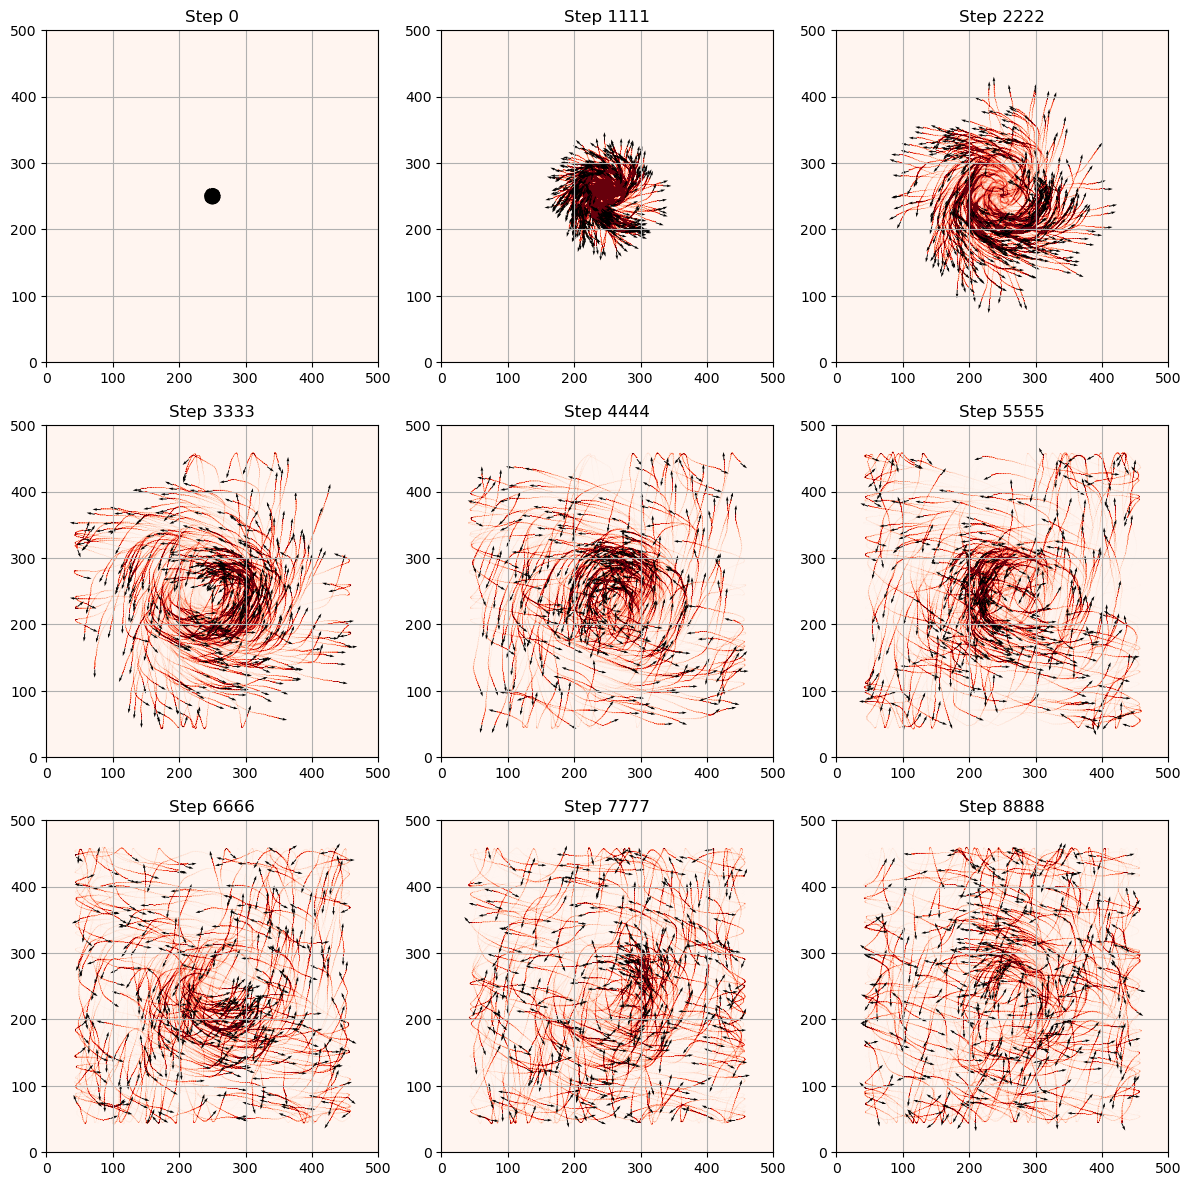

In [18]:
# Plot the positions and use the color for the velocities and pheromone history
import matplotlib.pyplot as plt
import numpy as np

# Convert JAX arrays to NumPy for plotting
position_history_np = np.array(position_history)
velocity_history_np = np.array(velocity_history)
pheromone_history_np = np.array(pheromone_history)

# Normalize the velocities for color mapping
abs_velocities = np.linalg.norm(velocity_history_np, axis=-1)
velocity_history_np = velocity_history_np / (abs_velocities[..., None] + 1e-8)  # Normalize to unit vectors

# Plot the simulation at 9 different time points in a 3x3 grid
use_velocity = True
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axs.flat):
    step = i * (num_steps // 9)
    ax.set_title(f"Step {step}")
    ax.set_aspect('equal')
    ax.grid()

    # Plot the pheromone grid as a red heatmap with alpha indicating decay
    pheromone_grid = pheromone_history_np[step]
    ax.imshow(pheromone_grid.T, origin='lower', cmap='Reds', alpha=1, extent=(0, space_size, 0, space_size), vmax=1)

    # Plot the boids
    if use_velocity:
        ax.quiver(position_history_np[step, :, 0], position_history_np[step, :, 1],
                  velocity_history_np[step, :, 0], velocity_history_np[step, :, 1],
                  angles='xy', scale_units='xy')
    else:
        ax.scatter(position_history_np[step, :, 0], position_history_np[step, :, 1], c='blue', s=1)

plt.tight_layout()
plt.show()

In [113]:
def create_gif(position_history, velocity_history, pheromone_history, filename='boids_simulation.gif', fps=5, frame_step=10, use_arrows=True, window_size=100.0, space_size=100.0):
    """
    Create a GIF from the boids simulation with pheromone visualization.
    
    Args:
        position_history (jax.numpy.ndarray): History of positions at each step.
        velocity_history (jax.numpy.ndarray): History of velocities at each step.
        pheromone_history (jax.numpy.ndarray): History of pheromone grid at each step.
        filename (str): Name of the output GIF file.
        fps (int): Frames per second for the GIF.
        frame_step (int): Step size for selecting frames (e.g., every nth frame).
        use_arrows (bool): Whether to use arrows to represent velocities.
        window_size (float): Size of the plotting window.
        space_size (float): Size of the simulation space.
    """
    # Convert JAX arrays to NumPy for plotting
    position_history_np = np.array(position_history)
    velocity_history_np = np.array(velocity_history)
    pheromone_history_np = np.array(pheromone_history)

    # Normalize the velocities for consistent arrow scaling
    abs_velocities = np.linalg.norm(velocity_history_np, axis=-1)
    velocity_history_np = velocity_history_np / (abs_velocities[..., None] + 1e-8)  # Normalize to unit vectors

    images = []
    for i in range(0, position_history_np.shape[0], frame_step):
        fig, ax = plt.subplots()
        ax.set_xlim(0, window_size)
        ax.set_ylim(0, window_size)
        ax.set_aspect('equal')
        ax.set_xticks(np.arange(0, window_size + window_size % 10, window_size // 10))
        ax.set_yticks(np.arange(0, window_size + window_size % 10, window_size // 10))
        ax.grid()

        # Plot the pheromone grid as a red heatmap with alpha indicating decay
        pheromone_grid = pheromone_history_np[i]
        ax.imshow(pheromone_grid.T, origin='lower', cmap='Reds', alpha=1, extent=(0, space_size, 0, space_size), vmax=1)

        # Plot the boids
        if use_arrows:
            ax.quiver(position_history_np[i, :, 0], position_history_np[i, :, 1],
                      velocity_history_np[i, :, 0], velocity_history_np[i, :, 1],
                      angles='xy', scale_units='xy', color='blue')  # Fixed scale and width #scale=space_size/10, width=space_size/10000,
        else:
            ax.scatter(position_history_np[i, :, 0], position_history_np[i, :, 1], c='blue', s=10)

        plt.title(f"Step {i}")
        plt.tight_layout()

        # Save the current frame
        temp_filename = f"frame_{i}.png"
        plt.savefig(temp_filename)
        images.append(imageio.imread(temp_filename))
        plt.close(fig)

    # Create a GIF from the images
    imageio.mimsave(filename, images, fps=fps)

    # Clean up temporary files
    for temp_filename in [f"frame_{i}.png" for i in range(0, position_history_np.shape[0], frame_step)]:
        if os.path.exists(temp_filename):
            os.remove(temp_filename)

# Create the GIF with every 10th frame
create_gif(position_history, velocity_history, pheromone_history, filename=f'gifs/separateboids.gif', fps=10, frame_step=20, space_size=space_size, window_size=space_size, use_arrows=True)

/var/folders/_t/k7g7kxnn08gbcw98nd8r1qq40000gn/T/ipykernel_3934/3114992012.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(temp_filename))


In [86]:
for temp_filename in [f"frame_{i}.png" for i in range(0, position_history.shape[0], 10)]:
    if os.path.exists(temp_filename):
        os.remove(temp_filename)